<a href="https://colab.research.google.com/github/babak-tafreshi/AER850_Project2/blob/main/Project2_AER850.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# AER 850 Project 2
# Babak Nassir Tafreshi

In [3]:
# Setting up the environment


import os, pathlib, json, math, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow: 2.19.0
GPU available: True


# Step 1: Data Processing
Data processing is the first step to perform any type of image classification task. There are a few steps involved with this step.

• The first is to define the input image shape which is required to be (500,500, 3) which is the desired width, height and channel of the image for model training.

• Establish the train and validation data directory (use relative paths). The data is split into 3 folders - Train, Validation and Test which contain 1942, 431 and 539 images respectively.

• Perform data augmentation such as re-scaling, shear range and zoom range by using packages such as Keras’ image preprocessing pipeline, or torchvision transforms for the train data and validation data (only apply re-scaling for validation).

• Create the train and validation generator using Keras’s built-in imagedatasetfromdirectory function which takes in the data directory, image target size, batch size (32), and class mode (categorical) or by using PyTorch’s Dataloader.

In [24]:
# =========================
# AER850 Project - STEP 1: Data Processing (Keras + ImageDataGenerator)
# Colab-ready, reproducible, and matches assignment requirements
# =========================

import os, json, math, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------- USER: FILL THESE (use RELATIVE paths in your repo structure if possible) ---------
PATH_TRAIN = "/content/drive/MyDrive/AER 850/Project 2/train"        # e.g., "data/train"
PATH_VAL   = "/content/drive/MyDrive/AER 850/Project 2/valid"          # e.g., "data/val"
PATH_TEST  = "/content/drive/MyDrive/AER 850/Project 2/test"         # e.g., "data/test"
# -------------------------------------------------------------------------------------------

# Safety check for paths (friendly message, not a hard crash until you run the generators)
for p in [PATH_TRAIN, PATH_VAL, PATH_TEST]:
    if not isinstance(p, str) or p.strip() == "":
        raise ValueError("Please set PATH_TRAIN, PATH_VAL, PATH_TEST to your directories (relative paths).")
    if not os.path.isdir(p):
        print(f"[WARN] Directory not found yet: {p}. If you're on Colab, mount Drive and/or fix the paths.")

# -----------------------
# Reproducibility settings
# -----------------------
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.config.experimental.enable_op_determinism()

# -----------------------
# Core parameters
# -----------------------
IMG_HEIGHT, IMG_WIDTH, IMG_CH = 500, 500, 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CH)
BATCH_SIZE  = 32
COLOR_MODE  = "rgb"
CLASS_MODE  = "categorical"   # 3 classes

print(f"[INFO] Input shape: {INPUT_SHAPE} | Batch size: {BATCH_SIZE} | Class mode: {CLASS_MODE}")

# -----------------------
# ImageDataGenerators
# -----------------------
# Train: rescale + augment (shear, zoom, small rotations/translations, optional flips)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.15,           # satisfies "shear range" requirement
    zoom_range=0.15,            # satisfies "zoom range" requirement
    rotation_range=12,          # small, realistic rotations
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation: rescale only (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# Test: rescale only (for later Step 5; we define the generator now for counts & consistency)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# -----------------------
# Directory iterators
# -----------------------
# Each expects subfolders named exactly after the classes (crack, missing-head, paint-off)
# Shuffle train, do not shuffle val/test.
train_gen = train_datagen.flow_from_directory(
    directory=PATH_TRAIN,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    directory=PATH_VAL,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    directory=PATH_TEST,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)

# -----------------------
# Class mapping & save
# -----------------------
class_indices = train_gen.class_indices          # dict: {class_name: index}
inv_class_indices = {v: k for k, v in class_indices.items()}

print("\n[INFO] Class indices:", class_indices)
print("[INFO] Inverse map:  ", inv_class_indices)

# Save label map for later inference (Step 5)
os.makedirs("outputs", exist_ok=True)
with open("outputs/label_map.json", "w") as f:
    json.dump(class_indices, f, indent=2)
print('[INFO] Saved label map to "outputs/label_map.json"')

# -----------------------
# Dataset size checks
# -----------------------
n_train = train_gen.samples
n_val   = val_gen.samples
n_test  = test_gen.samples

print(f"\n[INFO] Sample counts -> Train: {n_train} | Val: {n_val} | Test: {n_test}")
EXPECTED = {"train": 1942, "val": 431, "test": 539}
for name, n, exp in [("Train", n_train, EXPECTED["train"]),
                     ("Val",   n_val,   EXPECTED["val"]),
                     ("Test",  n_test,  EXPECTED["test"])]:
    if n != exp:
        print(f"[WARN] {name} count is {n}, expected {exp}. Double-check your folders/files.")

# -----------------------
# Steps per epoch (ceil)
# -----------------------
steps_per_epoch      = int(math.ceil(n_train / BATCH_SIZE)) if n_train > 0 else 0
validation_steps     = int(math.ceil(n_val   / BATCH_SIZE)) if n_val   > 0 else 0
test_steps           = int(math.ceil(n_test  / BATCH_SIZE)) if n_test  > 0 else 0

print(f"\n[INFO] steps_per_epoch:   {steps_per_epoch}")
print(f"[INFO] validation_steps:  {validation_steps}")
print(f"[INFO] test_steps:        {test_steps}")

# Quick sanity batch to ensure pipeline works (only if there are samples)
if n_train > 0:
    xb, yb = next(iter(train_gen))
    print(f"\n[INFO] One training batch -> x: {xb.shape}, y: {yb.shape}, dtype: {xb.dtype}")
    assert xb.shape[1:] == (IMG_HEIGHT, IMG_WIDTH, IMG_CH), "Batch image shape mismatch!"
    assert yb.shape[1] == 3, "Expecting 3 classes (softmax outputs)."
else:
    print("\n[INFO] Skipped sanity batch: no training samples found yet.")


[INFO] Input shape: (500, 500, 3) | Batch size: 32 | Class mode: categorical
Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Found 539 images belonging to 3 classes.

[INFO] Class indices: {'crack': 0, 'missing-head': 1, 'paint-off': 2}
[INFO] Inverse map:   {0: 'crack', 1: 'missing-head', 2: 'paint-off'}
[INFO] Saved label map to "outputs/label_map.json"

[INFO] Sample counts -> Train: 1942 | Val: 431 | Test: 539

[INFO] steps_per_epoch:   61
[INFO] validation_steps:  14
[INFO] test_steps:        17

[INFO] One training batch -> x: (32, 500, 500, 3), y: (32, 3), dtype: float32


# STEP 2

In [25]:
# =========================
# AER850 Project - STEP 2: Neural Network Architecture Design
# Two custom CNN variants (A baseline, B improved), compiled and summarized
# =========================

import os, json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization,
                                     LeakyReLU)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# -----------------------
# Inherit shape/classes from Step 1 if available; else default
# -----------------------
DEFAULT_INPUT_SHAPE = (500, 500, 3)
DEFAULT_NUM_CLASSES = 3

INPUT_SHAPE = DEFAULT_INPUT_SHAPE
NUM_CLASSES = DEFAULT_NUM_CLASSES

# If Step 1 ran, try to reuse its variables
try:
    # If train_gen exists, derive num classes from it.
    if 'train_gen' in globals() and hasattr(train_gen, 'num_classes'):
        NUM_CLASSES = int(train_gen.num_classes)
    # If INPUT_SHAPE existed in Step 1, keep it
    if 'INPUT_SHAPE' in globals():
        INPUT_SHAPE = tuple(INPUT_SHAPE)
except Exception:
    pass

print(f"[INFO] Using INPUT_SHAPE={INPUT_SHAPE}, NUM_CLASSES={NUM_CLASSES}")

# -----------------------
# Building blocks
# -----------------------
def conv_block(x, filters, k=3, s=1, use_bn=False, activation='relu', name_prefix='cb'):
    """A simple Conv2D -> (BN) -> Activation -> MaxPool block."""
    x = Conv2D(filters, kernel_size=(k, k), strides=(s, s), padding='same',
               kernel_initializer='he_normal', name=f'{name_prefix}_conv')(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.1, name=f'{name_prefix}_lrelu')(x)
    else:
        x = tf.keras.layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return x

def dense_head(x, units=128, dropout=0.5, use_bn=False, activation='relu',
               num_classes=3, l2_reg=None, name_prefix='head'):
    """Flatten -> Dense(units) -> (BN) -> Activation -> Dropout -> Dense(num_classes, softmax)"""
    x = Flatten(name=f'{name_prefix}_flatten')(x)
    kwargs = {}
    if l2_reg is not None and l2_reg > 0:
        kwargs['kernel_regularizer'] = l2(l2_reg)
    x = Dense(units, name=f'{name_prefix}_dense', **kwargs)(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if activation == 'elu':
        x = tf.keras.layers.Activation('elu', name=f'{name_prefix}_elu')(x)
    else:
        x = tf.keras.layers.Activation('relu', name=f'{name_prefix}_relu')(x)
    if dropout and dropout > 0:
        x = Dropout(dropout, name=f'{name_prefix}_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    return outputs

# -----------------------
# Variant A (Baseline): Simple, clean CNN
# -----------------------
def build_cnn_variant_a(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Baseline: 4 conv blocks with filters [32, 64, 128, 256], ReLU, no BN,
    Flatten -> Dense(128, relu) -> Dropout(0.5) -> Dense(3, softmax)
    """
    inputs = Input(shape=input_shape, name='input')
    x = conv_block(inputs, 32, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb1')
    x = conv_block(x,      64, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb2')
    x = conv_block(x,     128, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb3')
    x = conv_block(x,     256, k=3, s=1, use_bn=False, activation='relu', name_prefix='a_cb4')
    outputs = dense_head(x, units=128, dropout=0.5, use_bn=False,
                         activation='relu', num_classes=num_classes,
                         l2_reg=None, name_prefix='a_head')
    model = Model(inputs, outputs, name='CNN_Variant_A_Baseline')
    return model

# -----------------------
# Variant B (Improved): BN, LeakyReLU in convs, stronger regularization
# -----------------------
def build_cnn_variant_b(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    """
    Improved: 4 conv blocks with filters [64, 128, 256, 256], BatchNorm, LeakyReLU,
    Flatten -> Dense(256, ELU) -> Dropout(0.6) -> Dense(3, softmax).
    Slight L2 on dense to discourage overfitting.
    """
    inputs = Input(shape=input_shape, name='input')
    x = conv_block(inputs,  64, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb1')
    x = conv_block(x,      128, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb2')
    x = conv_block(x,      256, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb3')
    x = conv_block(x,      256, k=3, s=1, use_bn=True, activation='leaky_relu', name_prefix='b_cb4')
    outputs = dense_head(x, units=256, dropout=0.6, use_bn=True,
                         activation='elu', num_classes=num_classes,
                         l2_reg=1e-4, name_prefix='b_head')
    model = Model(inputs, outputs, name='CNN_Variant_B_Improved')
    return model

# -----------------------
# Build and compile both
# -----------------------
os.makedirs("models", exist_ok=True)

model_a = build_cnn_variant_a()
model_b = build_cnn_variant_b()

# Default compile (Step 3 will explore alternatives)
model_a.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model_b.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Print summaries
print("\n" + "="*80)
print("Model A (Baseline) Summary")
print("="*80)
model_a.summary()
print("\n" + "="*80)
print("Model B (Improved) Summary")
print("="*80)
model_b.summary()

# -----------------------
# Optional quick forward-pass sanity check (batch=1 to avoid memory spikes)
# -----------------------
try:
    dummy = np.random.rand(1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]).astype('float32')
    pa = model_a.predict(dummy, verbose=0)
    pb = model_b.predict(dummy, verbose=0)
    assert pa.shape == (1, NUM_CLASSES) and pb.shape == (1, NUM_CLASSES), "Output shape mismatch."
    print("\n[INFO] Sanity forward pass OK. Outputs:", pa.shape, pb.shape)
except Exception as e:
    print(f"\n[WARN] Sanity forward pass skipped/failed: {e}")


[INFO] Using INPUT_SHAPE=(500, 500, 3), NUM_CLASSES=3

Model A (Baseline) Summary


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "CNN_Variant_A_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb1_conv (Conv2D)             │ (None, 500, 500, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb1_relu (Activation)         │ (None, 500, 500, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb1_pool (MaxPooling2D)       │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb2_conv (Conv2D)             │ (None, 250, 250, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb2_relu (Activation)         │ (None, 250, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb2_pool (MaxPooling2D)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb3_conv (Conv2D)             │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb3_relu (Activation)         │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb3_pool (MaxPooling2D)       │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb4_conv (Conv2D)             │ (None, 62, 62, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb4_relu (Activation)         │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_cb4_pool (MaxPooling2D)       │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_flatten (Flatten)        │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_dense (Dense)            │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_relu (Activation)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ a_head_dropout (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,878,979 (121.61 MB)

 Trainable params: 31,878,979 (121.61 MB)

 Non-trainable params: 0 (0.00 B)


Model B (Improved) Summary


Model: "CNN_Variant_B_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_conv (Conv2D)             │ (None, 500, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_bn (BatchNormalization)   │ (None, 500, 500, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_lrelu (LeakyReLU)         │ (None, 500, 500, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb1_pool (MaxPooling2D)       │ (None, 250, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_conv (Conv2D)             │ (None, 250, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_bn (BatchNormalization)   │ (None, 250, 250, 128)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_lrelu (LeakyReLU)         │ (None, 250, 250, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb2_pool (MaxPooling2D)       │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_conv (Conv2D)             │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_bn (BatchNormalization)   │ (None, 125, 125, 256)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_lrelu (LeakyReLU)         │ (None, 125, 125, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb3_pool (MaxPooling2D)       │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_conv (Conv2D)             │ (None, 62, 62, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_bn (BatchNormalization)   │ (None, 62, 62, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_lrelu (LeakyReLU)         │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_cb4_pool (MaxPooling2D)       │ (None, 31, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_flatten (Flatten)        │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_dense (Dense)            │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_bn (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_elu (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ b_head_dropout (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,945,859 (243.93 MB)

 Trainable params: 63,943,939 (243.93 MB)

 Non-trainable params: 1,920 (7.50 KB)


[INFO] Sanity forward pass OK. Outputs: (1, 3) (1, 3)


# STEP 3

In [26]:
# =========================
# AER850 Project - STEP 3: Hyperparameter Analysis (setup only)
# - Define a small, meaningful hyperparameter search space
# - Build & compile candidate models
# - Print a compact summary table for quick comparison
# Training/evaluation will be in STEP 4.
# =========================

import os, math, json, pprint
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization, LeakyReLU, Activation)
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd

# -----------------------
# Safe defaults / inherit from Step 1
# -----------------------
DEFAULT_INPUT_SHAPE = (500, 500, 3)
DEFAULT_NUM_CLASSES = 3

INPUT_SHAPE = DEFAULT_INPUT_SHAPE
NUM_CLASSES = DEFAULT_NUM_CLASSES

try:
    if 'INPUT_SHAPE' in globals() and isinstance(INPUT_SHAPE, tuple):
        INPUT_SHAPE = tuple(INPUT_SHAPE)
    if 'train_gen' in globals() and hasattr(train_gen, 'num_classes'):
        NUM_CLASSES = int(train_gen.num_classes)
except Exception:
    pass

print(f"[INFO] Hyperparam setup using INPUT_SHAPE={INPUT_SHAPE}, NUM_CLASSES={NUM_CLASSES}")

# -----------------------
# Building blocks (conv block + dense head) following assignment (uses Flatten)
# -----------------------
def conv_block(x, filters, k=3, s=1, use_bn=False, conv_activation='relu', name_prefix='cb'):
    x = Conv2D(filters, (k, k), strides=(s, s), padding='same',
               kernel_initializer='he_normal', name=f'{name_prefix}_conv')(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if conv_activation == 'leaky_relu':
        x = LeakyReLU(alpha=0.1, name=f'{name_prefix}_lrelu')(x)
    else:
        x = Activation('relu', name=f'{name_prefix}_relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name=f'{name_prefix}_pool')(x)
    return x

def dense_head(x, dense_units=128, dropout=0.5, use_bn=False,
               dense_activation='relu', num_classes=3, l2_reg=None, name_prefix='head'):
    x = Flatten(name=f'{name_prefix}_flatten')(x)
    kwargs = {}
    if l2_reg is not None and l2_reg > 0:
        kwargs['kernel_regularizer'] = l2(l2_reg)
    x = Dense(dense_units, name=f'{name_prefix}_dense', **kwargs)(x)
    if use_bn:
        x = BatchNormalization(name=f'{name_prefix}_bn')(x)
    if dense_activation == 'elu':
        x = Activation('elu', name=f'{name_prefix}_elu')(x)
    else:
        x = Activation('relu', name=f'{name_prefix}_relu')(x)
    if dropout and dropout > 0:
        x = Dropout(dropout, name=f'{name_prefix}_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    return outputs

def build_custom_cnn(hp):
    """
    hp dict keys (examples):
      - filters: [32,64,128,256]
      - kernel_size: 3
      - use_bn: True/False
      - conv_activation: 'relu' or 'leaky_relu'
      - dense_units: 128/256
      - dense_activation: 'relu' or 'elu'
      - dropout: 0.5/0.6
      - l2_reg: float or None
    """
    inputs = Input(shape=INPUT_SHAPE, name='input')
    x = inputs
    for i, f in enumerate(hp['filters'], start=1):
        x = conv_block(
            x, filters=f, k=hp.get('kernel_size', 3), s=1,
            use_bn=hp.get('use_bn', False),
            conv_activation=hp.get('conv_activation', 'relu'),
            name_prefix=f"cb{i}"
        )
    outputs = dense_head(
        x,
        dense_units=hp.get('dense_units', 128),
        dropout=hp.get('dropout', 0.5),
        use_bn=hp.get('use_bn_head', False),
        dense_activation=hp.get('dense_activation', 'relu'),
        num_classes=NUM_CLASSES,
        l2_reg=hp.get('l2_reg', None),
        name_prefix="head"
    )
    model = Model(inputs, outputs, name=hp.get('name', 'CustomCNN'))
    return model

def make_optimizer(name='adam', lr=1e-3):
    name = name.lower()
    if name == 'adam':
        return Adam(learning_rate=lr)
    if name == 'sgd':
        return SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    if name == 'rmsprop':
        return RMSprop(learning_rate=lr, rho=0.9, momentum=0.0)
    raise ValueError(f"Unknown optimizer '{name}'")

# -----------------------
# Hyperparameter candidates (small, meaningful grid)
# - A: ReLU conv + ReLU dense, modest filters, Adam 1e-3
# - B: LeakyReLU conv + ELU dense, stronger filters, BN, Dropout 0.6, L2, Adam 1e-3
# - C: ReLU conv + ELU dense, slightly bigger dense head, SGD (to compare optimizer behavior)
# - D: LeakyReLU conv, same as B but with RMSprop + different LR
# -----------------------
HP_TRIALS = [
    {
        "name": "A_relu_relu_32-64-128-256_adam1e-3",
        "filters": [32, 64, 128, 256],
        "kernel_size": 3,
        "use_bn": False,
        "use_bn_head": False,
        "conv_activation": "relu",
        "dense_units": 128,
        "dense_activation": "relu",
        "dropout": 0.5,
        "l2_reg": None,
        "optimizer": "adam",
        "lr": 1e-3,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
    {
        "name": "B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2",
        "filters": [64, 128, 256, 256],
        "kernel_size": 3,
        "use_bn": True,
        "use_bn_head": True,
        "conv_activation": "leaky_relu",
        "dense_units": 256,
        "dense_activation": "elu",
        "dropout": 0.6,
        "l2_reg": 1e-4,
        "optimizer": "adam",
        "lr": 1e-3,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
    {
        "name": "C_relu_elu_32-64-128-256_sgd2e-2",
        "filters": [32, 64, 128, 256],
        "kernel_size": 3,
        "use_bn": False,
        "use_bn_head": False,
        "conv_activation": "relu",
        "dense_units": 256,
        "dense_activation": "elu",
        "dropout": 0.5,
        "l2_reg": None,
        "optimizer": "sgd",
        "lr": 2e-2,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
    {
        "name": "D_lrelu_elu_64-128-256-256_rmsprop5e-4_bn",
        "filters": [64, 128, 256, 256],
        "kernel_size": 3,
        "use_bn": True,
        "use_bn_head": True,
        "conv_activation": "leaky_relu",
        "dense_units": 256,
        "dense_activation": "elu",
        "dropout": 0.6,
        "l2_reg": None,
        "optimizer": "rmsprop",
        "lr": 5e-4,
        "loss": "categorical_crossentropy",
        "metrics": ["accuracy"]
    },
]

# -----------------------
# Build + compile; collect a summary table (no training yet)
# -----------------------
MODELS = {}       # name -> compiled model
HP_TABLE = []     # rows with config + param counts

for hp in HP_TRIALS:
    model = build_custom_cnn(hp)
    opt = make_optimizer(hp["optimizer"], hp["lr"])
    model.compile(optimizer=opt, loss=hp["loss"], metrics=hp["metrics"])
    MODELS[hp["name"]] = model

    # Count params and log
    total_params = model.count_params()
    HP_TABLE.append({
        "name": hp["name"],
        "filters": "-".join(map(str, hp["filters"])),
        "conv_act": hp["conv_activation"],
        "dense_units": hp["dense_units"],
        "dense_act": hp["dense_activation"],
        "dropout": hp["dropout"],
        "bn": hp["use_bn"],
        "bn_head": hp["use_bn_head"],
        "l2_reg": hp["l2_reg"] if hp["l2_reg"] is not None else 0.0,
        "optimizer": hp["optimizer"],
        "lr": hp["lr"],
        "total_params": total_params
    })

hp_df = pd.DataFrame(HP_TABLE)
pd.set_option("display.max_colwidth", None)
print("\n[INFO] Hyperparameter Candidates:")
display(hp_df)

# -----------------------
# Quick sanity forward pass on each model (batch=1) to ensure no shape errors
# -----------------------
try:
    dummy = np.random.rand(1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]).astype('float32')
    for name, model in MODELS.items():
        out = model.predict(dummy, verbose=0)
        assert out.shape == (1, NUM_CLASSES), f"{name}: unexpected output shape {out.shape}"
    print("\n[INFO] Sanity forward-pass OK for all candidates.")
except Exception as e:
    print(f"\n[WARN] Sanity forward-pass check failed: {e}")

# Save a small JSON with the chosen HP grid (useful for the report & reproducibility)
os.makedirs("outputs", exist_ok=True)
with open("outputs/hparam_candidates.json", "w") as f:
    json.dump(HP_TRIALS, f, indent=2)
print('[INFO] Saved hyperparameter candidates to "outputs/hparam_candidates.json"')

# MODELS dict is now ready for Step 4 training, e.g.,
#   model = MODELS["B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2"]
# We will also add callbacks (EarlyStopping, ReduceLROnPlateau) in Step 4.


[INFO] Hyperparam setup using INPUT_SHAPE=(500, 500, 3), NUM_CLASSES=3

[INFO] Hyperparameter Candidates:


,name,filters,conv_act,dense_units,dense_act,dropout,bn,bn_head,l2_reg,optimizer,lr,total_params
0,A_relu_relu_32-64-128-256_adam1e-3,32-64-128-256,relu,128,relu,0.5,False,False,0.0000,adam,0.0010,31878979
1,B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2,64-128-256-256,leaky_relu,256,elu,0.6,True,True,0.0001,adam,0.0010,63945859
2,C_relu_elu_32-64-128-256_sgd2e-2,32-64-128-256,relu,256,elu,0.5,False,False,0.0000,sgd,0.0200,63369539
3,D_lrelu_elu_64-128-256-256_rmsprop5e-4_bn,64-128-256-256,leaky_relu,256,elu,0.6,True,True,0.0000,rmsprop,0.0005,63945859



[INFO] Sanity forward-pass OK for all candidates.
[INFO] Saved hyperparameter candidates to "outputs/hparam_candidates.json"


# STEP **4**

[INFO] Using models from: Step 3 (MODELS)
 - A_relu_relu_32-64-128-256_adam1e-3: params=31,878,979
 - B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2: params=63,945,859

[TRAIN] A_relu_relu_32-64-128-256_adam1e-3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4076 - loss: 11.6924 
Epoch 1: val_accuracy improved from -inf to 0.55684, saving model to models/A_relu_relu_32-64-128-256_adam1e-3_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 1335s 22s/step - accuracy: 0.4085 - loss: 11.5713 - val_accuracy: 0.5568 - val_loss: 0.8961 - learning_rate: 0.0010
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6034 - loss: 0.8915
Epoch 2: val_accuracy improved from 0.55684 to 0.59861, saving model to models/A_relu_relu_32-64-128-256_adam1e-3_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6032 - loss: 0.8915 - val_accuracy: 0.5986 - val_loss: 0.7929 - learning_rate: 0.0010
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6363 - loss: 0.8248
Epoch 3: val_accuracy improved from 0.59861 to 0.60557, saving model to models/A_relu_relu_32-64-128-256_adam1e-3_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6361 - loss: 0.8252 - val_accuracy: 0.6

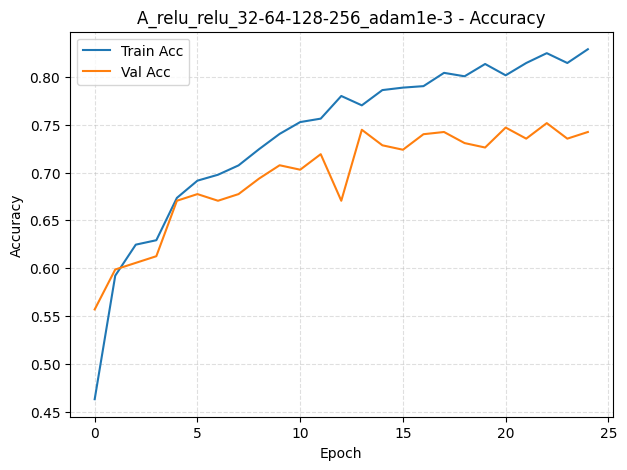

[INFO] Saved: outputs/curves/A_relu_relu_32-64-128-256_adam1e-3_accuracy.png


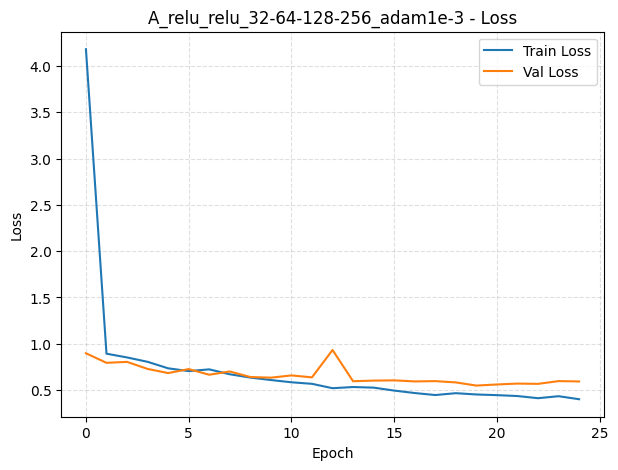

[INFO] Saved: outputs/curves/A_relu_relu_32-64-128-256_adam1e-3_loss.png

[TRAIN] B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2
Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2_1/cb3_bn_1/moments/SquaredDifference defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-370714270.py", line 150, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 254, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 314, in _moments

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py", line 2159, in moments

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py", line 820, in moments

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py", line 863, in _compute_moments

failed to allocate memory
	 [[{{node B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2_1/cb3_bn_1/moments/SquaredDifference}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_38269]

In [27]:
# =========================
# AER850 Project - STEP 4: Model Evaluation (Training + Curves)
# Trains two custom CNN variants (A: Baseline, B: Improved),
# plots/saves Train vs Val Accuracy & Loss (Figure-2 style),
# and writes histories and best weights to disk.
# =========================

import os, json, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -----------------------
# Preconditions: data generators from Step 1
# -----------------------
REQUIRED = ['train_gen', 'val_gen']
missing = [name for name in REQUIRED if name not in globals()]
if missing:
    raise RuntimeError(f"Missing {missing}. Please run Step 1 cell first to create train_gen/val_gen.")

# If Step 1 didn't compute steps, compute now.
if 'steps_per_epoch' not in globals() or steps_per_epoch == 0:
    steps_per_epoch = int(math.ceil(train_gen.samples / train_gen.batch_size)) if train_gen.samples > 0 else 0
if 'validation_steps' not in globals() or validation_steps == 0:
    validation_steps = int(math.ceil(val_gen.samples / val_gen.batch_size)) if val_gen.samples > 0 else 0

if steps_per_epoch == 0 or validation_steps == 0:
    raise RuntimeError("Empty train/val datasets or batch size incorrectly set. Please verify Step 1 paths.")

# -----------------------
# Output dirs
# -----------------------
os.makedirs("models", exist_ok=True)
os.makedirs("outputs/curves", exist_ok=True)
os.makedirs("outputs/histories", exist_ok=True)

# -----------------------
# Bring (or build) the two models
# Priority order:
# 1) Use MODELS from Step 3 if available and names match A/B candidates.
# 2) Use builders from Step 2: build_cnn_variant_a / build_cnn_variant_b.
# 3) As a last resort, define minimal inline versions.
# -----------------------
model_entries = []

def compile_default(m):
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

used_source = None
if 'MODELS' in globals() and isinstance(MODELS, dict):
    # Try to pick A and B from Step 3 names if present
    name_a = "A_relu_relu_32-64-128-256_adam1e-3"
    name_b = "B_lrelu_elu_64-128-256-256_adam1e-3_bn_l2"
    if name_a in MODELS and name_b in MODELS:
        model_entries = [(name_a, MODELS[name_a]), (name_b, MODELS[name_b])]
        used_source = "Step 3 (MODELS)"
    else:
        # Fallback: take first two from MODELS
        keys = list(MODELS.keys())
        if len(keys) >= 2:
            model_entries = [(keys[0], MODELS[keys[0]]), (keys[1], MODELS[keys[1]])]
            used_source = "Step 3 (MODELS - generic)"
if not model_entries:
    # Try Step 2 builders
    if 'build_cnn_variant_a' in globals() and 'build_cnn_variant_b' in globals():
        model_a = compile_default(build_cnn_variant_a())
        model_b = compile_default(build_cnn_variant_b())
        model_entries = [("CNN_Variant_A_Baseline", model_a),
                         ("CNN_Variant_B_Improved", model_b)]
        used_source = "Step 2 builders"
if not model_entries:
    # Last resort inline builders (match assignment: Conv→Pool→...→Flatten→Dense/Dropout→Softmax)
    from tensorflow.keras import Model
    from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                         Dense, Dropout, BatchNormalization, LeakyReLU)
    INPUT_SHAPE = (500, 500, 3)
    NUM_CLASSES = 3

    def conv_block(x, filters, k=3, use_bn=False, leaky=False, pfx='cb'):
        x = Conv2D(filters, (k, k), padding='same', kernel_initializer='he_normal', name=f"{pfx}_conv")(x)
        if use_bn:
            x = BatchNormalization(name=f"{pfx}_bn")(x)
        x = (LeakyReLU(0.1, name=f"{pfx}_lrelu") if leaky
             else tf.keras.layers.Activation('relu', name=f"{pfx}_relu"))(x)
        x = MaxPooling2D((2, 2), name=f"{pfx}_pool")(x)
        return x

    def build_a():
        inp = Input(INPUT_SHAPE)
        x = conv_block(inp, 32, pfx='a1')
        x = conv_block(x, 64, pfx='a2')
        x = conv_block(x, 128, pfx='a3')
        x = conv_block(x, 256, pfx='a4')
        x = Flatten(name='a_flatten')(x)
        x = Dense(128, activation='relu', name='a_fc')(x)
        x = Dropout(0.5, name='a_do')(x)
        out = Dense(NUM_CLASSES, activation='softmax', name='a_softmax')(x)
        return Model(inp, out, name='CNN_Variant_A_Baseline')

    def build_b():
        inp = Input(INPUT_SHAPE)
        x = conv_block(inp, 64, use_bn=True, leaky=True, pfx='b1')
        x = conv_block(x, 128, use_bn=True, leaky=True, pfx='b2')
        x = conv_block(x, 256, use_bn=True, leaky=True, pfx='b3')
        x = conv_block(x, 256, use_bn=True, leaky=True, pfx='b4')
        x = Flatten(name='b_flatten')(x)
        x = Dense(256, activation='elu', name='b_fc')(x)
        x = Dropout(0.6, name='b_do')(x)
        out = Dense(NUM_CLASSES, activation='softmax', name='b_softmax')(x)
        return Model(inp, out, name='CNN_Variant_B_Improved')

    model_a = compile_default(build_a())
    model_b = compile_default(build_b())
    model_entries = [("CNN_Variant_A_Baseline", model_a),
                     ("CNN_Variant_B_Improved", model_b)]
    used_source = "Inline fallback"

print(f"[INFO] Using models from: {used_source}")
for n, m in model_entries:
    print(f" - {n}: params={m.count_params():,}")

# -----------------------
# Callbacks (safe, general)
# -----------------------
def make_callbacks(tag):
    ckp_path = f"models/{tag}_best.keras"   # TF2 native format
    return [
        ModelCheckpoint(ckp_path, monitor='val_accuracy', mode='max',
                        save_best_only=True, save_weights_only=False, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                          min_lr=1e-6, verbose=1)
    ]

# -----------------------
# Train loop
# -----------------------
HISTORIES = {}
EPOCHS = 30  # enough to see curves; EarlyStopping will cap if overfitting

for tag, model in model_entries:
    print("\n" + "="*80)
    print(f"[TRAIN] {tag}")
    print("="*80)
    callbacks = make_callbacks(tag)
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        verbose=1,
        callbacks=callbacks
    )
    HISTORIES[tag] = history.history

    # Save history JSON
    with open(f"outputs/histories/{tag}_history.json", "w") as f:
        json.dump(history.history, f, indent=2)

    # -----------------------
    # Plot Accuracy
    # -----------------------
    plt.figure(figsize=(7,5))
    plt.plot(history.history.get('accuracy', []), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', []), label='Val Acc')
    plt.title(f'{tag} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    acc_path = f"outputs/curves/{tag}_accuracy.png"
    plt.savefig(acc_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"[INFO] Saved: {acc_path}")

    # -----------------------
    # Plot Loss
    # -----------------------
    plt.figure(figsize=(7,5))
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.title(f'{tag} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    loss_path = f"outputs/curves/{tag}_loss.png"
    plt.savefig(loss_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"[INFO] Saved: {loss_path}")

# -----------------------
# Quick scoreboard (best val metrics)
# -----------------------
def best_val_metric(hist, key):
    arr = hist.get(key, [])
    return float(np.max(arr)) if arr else float('nan')

print("\n[RESULTS] Best validation metrics:")
for tag, hist in HISTORIES.items():
    best_acc = best_val_metric(hist, 'val_accuracy')
    best_loss = float(np.min(hist.get('val_loss', [np.nan])))
    print(f" - {tag}: best Val Acc = {best_acc:.4f} | best Val Loss = {best_loss:.4f}")
